In [1]:
import pywt

def channel_transform_advanced(ch1, ch2, level=2):
    coeffs1 = pywt.wavedec2(ch1, 'db5', mode='periodization', level=level)
    coeffs2 = pywt.wavedec2(ch2, 'db5', mode='periodization', level=level)
    
    fused_coeffs = []
    for c1, c2 in zip(coeffs1, coeffs2):
        if isinstance(c1, tuple):
            # Fuse the detail coefficients using a more sophisticated rule, like taking the maximum
            fused_coeffs.append(tuple((np.maximum(detail1, detail2) for detail1, detail2 in zip(c1, c2))))
        else:
            # Average the approximation coefficients
            fused_coeffs.append((c1 + c2) / 2)
    
    return pywt.waverec2(fused_coeffs, 'db5', mode='periodization')

# You would need to adjust the rest of your fusion function to use this new channel transform function.


In [2]:
import pywt
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim

def wavelet_decompose(image, wavelet='db5', level=2):
    """ Decompose an image into wavelet coefficients up to the specified level. """
    coeffs = pywt.wavedec2(image, wavelet, mode='periodization', level=level)
    return coeffs

def wavelet_reconstruct(coeffs, wavelet='db5'):
    """ Reconstruct an image from wavelet coefficients. """
    return pywt.waverec2(coeffs, wavelet, mode='periodization')


def pad_coefficients(c1, c2):
    # Calculate padding amounts
    pad_rows = abs(c1.shape[0] - c2.shape[0])
    pad_cols = abs(c1.shape[1] - c2.shape[1])
    
    # Apply padding to the smaller array
    if c1.shape[0] < c2.shape[0]:
        c1 = np.pad(c1, ((0, pad_rows), (0, 0)), 'symmetric')
    else:
        c2 = np.pad(c2, ((0, pad_rows), (0, 0)), 'symmetric')
    
    if c1.shape[1] < c2.shape[1]:
        c1 = np.pad(c1, ((0, 0), (0, pad_cols)), 'symmetric')
    else:
        c2 = np.pad(c2, ((0, 0), (0, pad_cols)), 'symmetric')
    
    return c1, c2

def fuse_coefficients(coeffs1, coeffs2, method='average'):
    """ Fuse the wavelet coefficients from two images. """
    fused_coeffs = []
    for i, (c1, c2) in enumerate(zip(coeffs1, coeffs2)):
        if isinstance(c1, tuple):  # Detail coefficients
            temp = []
            for detail1, detail2 in zip(c1, c2):
                detail1, detail2 = pad_coefficients(detail1, detail2)
                if method == 'average':
                    temp.append((detail1 + detail2) / 2)
                elif method == 'min':
                    temp.append(np.minimum(detail1, detail2))
                elif method == 'max':
                    temp.append(np.maximum(detail1, detail2))
            fused_coeffs.append(tuple(temp))
        else:  # Approximation coefficients
            c1, c2 = pad_coefficients(c1, c2)
            if method == 'average':
                fused_coeffs.append((c1 + c2) / 2)
            elif method == 'min':
                fused_coeffs.append(np.minimum(c1, c2))
            elif method == 'max':
                fused_coeffs.append(np.maximum(c1, c2))
    return fused_coeffs



def fusion_process(img1, img2, wavelet='db5', level=2, fusion_method='average'):
    """ Perform the fusion of two images. """
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Decompose both images
    coeffs1 = wavelet_decompose(img1_gray, wavelet, level)
    coeffs2 = wavelet_decompose(img2_gray, wavelet, level)
    
    # Fuse coefficients
    fused_coeffs = fuse_coefficients(coeffs1, coeffs2, fusion_method)
    
    # Reconstruct the image based on the fused coefficients
    fused_image = wavelet_reconstruct(fused_coeffs, wavelet)
    
    # Normalize the pixel values
    fused_image = np.clip(fused_image, 0, 255)
    fused_image = fused_image.astype(np.uint8)
    
    # Quality metrics
    sim1 = ssim(img1_gray, fused_image)
    sim2 = ssim(img2_gray, fused_image)
    
    return fused_image, sim1, sim2

def resize_for_wavelet(image1, image2, level):
    """ Resize both images to the same dimensions suitable for wavelet decomposition. """
    factor = 2**level
    new_width = min(image1.shape[1], image2.shape[1]) // factor * factor
    new_height = min(image1.shape[0], image2.shape[0]) // factor * factor
    
    resized_image1 = cv2.resize(image1, (new_width, new_height), interpolation=cv2.INTER_AREA)
    resized_image2 = cv2.resize(image2, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    return resized_image1, resized_image2

# Load images
img1 = cv2.imread('/Users/chintubharath/Documents/sdp/medical1.png')
img2 = cv2.imread('/Users/chintubharath/Documents/sdp/medical2.png')

# Resize images to be compatible with wavelet decomposition
img1, img2 = resize_for_wavelet(img1, img2, level=2)

# Now run the fusion process
fused_image, sim1, sim2 = fusion_process(img1, img2)
print(f"SSIM with image 1: {sim1}, SSIM with image 2: {sim2}")


SSIM with image 1: 0.38224037463611715, SSIM with image 2: 0.6378447773448597


Images loaded successfully.
SSIM with image 1: 0.38224037463611715, SSIM with image 2: 0.6378447773448597


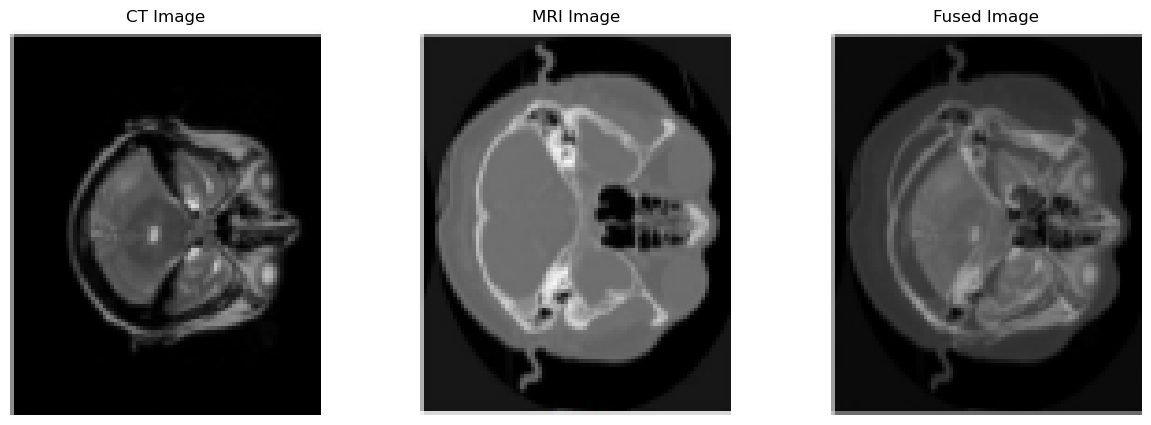

In [3]:
import matplotlib.pyplot as plt

def plot_images(ct_image, mri_image, fused_image):
    # Convert from BGR to RGB
    ct_image_rgb = cv2.cvtColor(ct_image, cv2.COLOR_BGR2RGB)
    mri_image_rgb = cv2.cvtColor(mri_image, cv2.COLOR_BGR2RGB)
    fused_image_rgb = cv2.cvtColor(fused_image, cv2.COLOR_BGR2RGB)
    
    # Create a figure with 3 subplots in one row
    plt.figure(figsize=(15, 5))
    
    # Plot CT image
    plt.subplot(1, 3, 1)
    plt.imshow(ct_image_rgb)
    plt.title('CT Image')
    plt.axis('off')
    
    # Plot MRI image
    plt.subplot(1, 3, 2)
    plt.imshow(mri_image_rgb)
    plt.title('MRI Image')
    plt.axis('off')
    
    # Plot Fused image
    plt.subplot(1, 3, 3)
    plt.imshow(fused_image_rgb)
    plt.title('Fused Image')
    plt.axis('off')
    
    # Display the plots
    plt.show()

# Load images
import cv2

img1 = cv2.imread('/Users/chintubharath/Documents/sdp/medical1.png')
img2 = cv2.imread('/Users/chintubharath/Documents/sdp/medical2.png')

if img1 is None or img2 is None:
    print("Failed to load images. Check file paths.")
else:
    print("Images loaded successfully.")



# Resize images to be compatible with wavelet decomposition
img1, img2 = resize_for_wavelet(img1, img2, level=2)

# Now run the fusion process
fused_image, sim1, sim2 = fusion_process(img1, img2)

# Display SSIM values
print(f"SSIM with image 1: {sim1}, SSIM with image 2: {sim2}")

# Plot and compare original and fused images
plot_images(img1, img2, fused_image)

In [4]:
x = random.randint(1000, 2000)
loc = '/Users/chintubharath/Documents/sdp/outputs/DWT_fused_image'+str(x)+'.ppg'

# Define the path where you want to save the fused image
save_path = "/Users/chintubharath/Documents/sdp/outputs/fused_image11.png"

# Create the directory if it does not exist
import os
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the fused image
cv2.imwrite(save_path, fused_image)

# Print a confirmation message
print(f"Fused image saved at: {save_path}")


Fused image saved at: /Users/chintubharath/Documents/sdp/outputs/fused_image11.png
